In [19]:
X_cols_names = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d', 'i_q']
y_cols_names = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

n_aggr = 60

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import random
import numpy as np

alt.data_transformers.enable("vegafusion")

pd.options.display.float_format = '{:.2f}'.format
df = pd.read_csv("data/measures_v2.csv")
df


,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.45,18.81,19.09,-0.35,18.29,0.00,0.00,0.00,24.55,18.32,19.85,0.19,17
1,-0.33,18.82,19.09,-0.31,18.29,0.00,0.00,-0.00,24.54,18.31,19.85,0.25,17
2,-0.44,18.83,19.09,-0.37,18.29,0.00,0.00,0.00,24.54,18.33,19.85,0.18,17
3,-0.33,18.84,19.08,-0.32,18.29,0.01,0.00,0.00,24.55,18.33,19.85,0.24,17
4,-0.47,18.86,19.08,-0.33,18.29,0.00,-0.06,0.04,24.57,18.33,19.85,0.21,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.15,30.72,45.27,0.79,41.93,0.00,-2.00,1.10,62.15,38.65,23.99,-0.00,71
1330812,-2.26,30.72,45.24,0.78,41.87,0.00,-2.00,1.10,62.14,38.66,23.97,-0.00,71
1330813,-2.13,30.72,45.21,0.80,41.80,0.00,-2.00,1.10,62.14,38.65,23.98,-0.00,71
1330814,-2.27,30.72,45.19,0.76,41.76,0.01,-2.00,1.10,62.13,38.66,24.00,-0.00,71


In [21]:
extra_feats = {
     'i_s': lambda x: np.sqrt(x['i_d']**2 + x['i_q']**2),  # Current vector norm
     'u_s': lambda x: np.sqrt(x['u_d']**2 + x['u_q']**2),  # Voltage vector norm
     'S_el': lambda x: x['i_s']*x['u_s'],                  # Apparent power
     'P_el': lambda x: x['i_d'] * x['u_d'] + x['i_q'] *x['u_q'],  # Effective power
}

In [22]:
df = df.assign(**extra_feats)
df

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id,i_s,u_s,S_el,P_el
0,-0.45,18.81,19.09,-0.35,18.29,0.00,0.00,0.00,24.55,18.32,19.85,0.19,17,0.00,0.57,0.00,-0.00
1,-0.33,18.82,19.09,-0.31,18.29,0.00,0.00,-0.00,24.54,18.31,19.85,0.25,17,0.00,0.45,0.00,0.00
2,-0.44,18.83,19.09,-0.37,18.29,0.00,0.00,0.00,24.54,18.33,19.85,0.18,17,0.00,0.58,0.00,-0.00
3,-0.33,18.84,19.08,-0.32,18.29,0.01,0.00,0.00,24.55,18.33,19.85,0.24,17,0.00,0.45,0.00,-0.00
4,-0.47,18.86,19.08,-0.33,18.29,0.00,-0.06,0.04,24.57,18.33,19.85,0.21,17,0.07,0.58,0.04,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.15,30.72,45.27,0.79,41.93,0.00,-2.00,1.10,62.15,38.65,23.99,-0.00,71,2.28,2.29,5.23,-3.95
1330812,-2.26,30.72,45.24,0.78,41.87,0.00,-2.00,1.10,62.14,38.66,23.97,-0.00,71,2.28,2.39,5.45,-4.04
1330813,-2.13,30.72,45.21,0.80,41.80,0.00,-2.00,1.10,62.14,38.65,23.98,-0.00,71,2.28,2.28,5.20,-3.95
1330814,-2.27,30.72,45.19,0.76,41.76,0.01,-2.00,1.10,62.13,38.66,24.00,-0.00,71,2.28,2.39,5.46,-4.01


In [23]:
ix_col = []
for profile_id in df["profile_id"].unique():
    profile_df = df[df["profile_id"] == profile_id]
    ix_col.extend(list(range(len(profile_df))))

df["ix_col"] = ix_col
df["agg_num"] = (df["ix_col"]) // n_aggr + 1


In [24]:
df_aggr = df.groupby(["profile_id", "agg_num"]).mean()
df_aggr

u_q  coolant  stator_winding   u_d  stator_tooth  \
profile_id agg_num                                                      
2          1        6.77    16.24           20.64 -5.26         18.79   
           2        8.19    16.95           29.88 -9.47         20.72   
           3        8.27    17.43           38.93 -9.51         25.09   
           4        8.33    17.95           46.18 -9.54         29.41   
           5        8.39    18.21           52.68 -9.56         33.47   
...                  ...      ...             ...   ...           ...   
81         291     -0.61    85.53           81.42 -0.71         79.46   
           292     -0.63    85.61           81.42 -0.71         79.46   
           293     -0.63    85.61           81.42 -0.71         79.46   
           294     -0.63    85.61           81.41 -0.71         79.46   
           295     -0.63    85.61           81.51 -0.71         79.46   

                    motor_speed     i_d    i_q    pm  stator_yoke  ambient  \
profile_id agg_num                                                           
2          1             100.08  -69.89 141.58 23.16        18.34    20.16   
           2              99.99 -122.97 242.42 23.21        18.83    21.13   
           3              99.99 -122.97 242.42 23.29        19.97    20.14   
           4              99.99 -122.97 242.42 23.38        22.94    20.36   
           5              99.99 -122.97 242.42 23.51        25.39    19.94   
...                         ...     ...    ...   ...          ...      ...   
81         291            -0.00   -2.00   1.10 58.09        80.30    24.84   
           292             0.00   -2.00   1.10 58.22        80.29    24.85   
           293            -0.00   -2.00   1.10 58.37        80.32    24.85   
           294             0.00   -2.00   1.10 58.51        80.32    24.84   
           295            -0.00   -2.00   1.10 58.61        80.30    24.87   

                    torque    i_s   u_s    S_el    P_el   ix_col  
profile_id agg_num                                                
2          1        120.32 158.05  9.22 1894.14 1758.34    29.50  
           2        208.23 271.83 12.52 3402.71 3149.42    89.50  
           3        208.13 271.83 12.60 3424.67 3173.31   149.50  
           4        208.03 271.83 12.66 3442.57 3192.75   209.50  
           5        207.93 271.83 12.72 3457.33 3208.89   269.50  
...                    ...    ...   ...     ...     ...      ...  
81         291       -0.00   2.28  0.94    2.14    0.75 17429.50  
           292       -0.00   2.28  0.95    2.18    0.74 17489.50  
           293       -0.00   2.28  0.95    2.16    0.73 17549.50  
           294       -0.00   2.28  0.95    2.18    0.73 17609.50  
           295       -0.00   2.28  0.95    2.18    0.73 17655.50  

[22216 rows x 17 columns]

In [25]:
df_aggr = df_aggr.reset_index().drop(["ix_col",  "agg_num"], axis="columns")
df_aggr

,profile_id,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,i_s,u_s,S_el,P_el
0,2,6.77,16.24,20.64,-5.26,18.79,100.08,-69.89,141.58,23.16,18.34,20.16,120.32,158.05,9.22,1894.14,1758.34
1,2,8.19,16.95,29.88,-9.47,20.72,99.99,-122.97,242.42,23.21,18.83,21.13,208.23,271.83,12.52,3402.71,3149.42
2,2,8.27,17.43,38.93,-9.51,25.09,99.99,-122.97,242.42,23.29,19.97,20.14,208.13,271.83,12.60,3424.67,3173.31
3,2,8.33,17.95,46.18,-9.54,29.41,99.99,-122.97,242.42,23.38,22.94,20.36,208.03,271.83,12.66,3442.57,3192.75
4,2,8.39,18.21,52.68,-9.56,33.47,99.99,-122.97,242.42,23.51,25.39,19.94,207.93,271.83,12.72,3457.33,3208.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22211,81,-0.61,85.53,81.42,-0.71,79.46,-0.00,-2.00,1.10,58.09,80.30,24.84,-0.00,2.28,0.94,2.14,0.75
22212,81,-0.63,85.61,81.42,-0.71,79.46,0.00,-2.00,1.10,58.22,80.29,24.85,-0.00,2.28,0.95,2.18,0.74
22213,81,-0.63,85.61,81.42,-0.71,79.46,-0.00,-2.00,1.10,58.37,80.32,24.85,-0.00,2.28,0.95,2.16,0.73
22214,81,-0.63,85.61,81.41,-0.71,79.46,0.00,-2.00,1.10,58.51,80.32,24.84,-0.00,2.28,0.95,2.18,0.73


In [26]:
ten_random_profiles = random.choices(list(df["profile_id"].unique()), k=10)
ten_random_profiles

[80, 36, 11, 31, 26, 29, 27, 11, 79, 42]

In [27]:
ten_profiles_target_df = df_aggr[df_aggr.profile_id.isin(ten_random_profiles)][y_cols_names + ["profile_id"]]
ten_profiles_target_df

def get_line_chart(df_name, y_col, color):
    return alt.Chart(df_name).mark_line(color=color).encode(x="time_id", y=y_col)

charts = []

for profile_id in ten_random_profiles:
    profile_df = df_aggr[df_aggr.profile_id == profile_id][y_cols_names].reset_index()
    profile_df["time_id"] = profile_df.index
    df_to_plot = profile_df[y_cols_names + ["time_id"]].melt(id_vars=["time_id"])
    charts.append(
        alt.Chart(df_to_plot).mark_line().encode(x="time_id", y="value:Q", color="variable").properties(
        width=800,
        height=200)
    )
   


In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_cols_names = X_cols_names + list(extra_feats.keys())

scaled_df = df_aggr
scaled_df[X_cols_names] = pd.DataFrame(scaler.fit_transform(df_aggr[X_cols_names]), columns=df_aggr.columns.drop(["profile_id"] + y_cols_names))

# picking 3 profiles for the test set:
test_profiles = [4, 27, 62]
test_df = scaled_df[scaled_df.profile_id.isin(test_profiles)]
train_df = scaled_df[~ scaled_df.profile_id.isin(test_profiles)]
len(test_df), len(train_df)


(1575, 20641)

In [29]:
X_train, y_train = train_df[X_cols_names], train_df["pm"]
X_test, y_test = test_df[X_cols_names], test_df["pm"]


X_train

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,i_s,u_s,S_el,P_el
0,-2.30,-0.92,0.33,-1.11,-1.14,1.18,-0.02,1.16,0.61,-1.38,-0.91,-0.28
1,-1.79,-0.89,0.26,-1.08,-1.14,2.35,-0.86,2.27,1.99,-1.32,-0.76,-0.16
2,-2.31,-0.86,0.26,-1.08,-1.14,2.35,-0.86,2.27,1.99,-1.32,-0.75,-0.16
3,-2.19,-0.84,0.26,-1.08,-1.14,2.35,-0.86,2.27,1.99,-1.31,-0.75,-0.16
4,-2.41,-0.83,0.26,-1.07,-1.14,2.35,-0.86,2.27,1.99,-1.31,-0.75,-0.16
...,...,...,...,...,...,...,...,...,...,...,...,...
22211,0.14,2.26,0.40,-1.28,-1.20,-0.41,1.06,-0.40,-1.27,-1.54,-1.10,-0.42
22212,0.15,2.27,0.40,-1.29,-1.20,-0.41,1.06,-0.40,-1.27,-1.54,-1.10,-0.42
22213,0.15,2.27,0.40,-1.29,-1.20,-0.41,1.06,-0.40,-1.27,-1.54,-1.10,-0.42
22214,0.14,2.27,0.40,-1.29,-1.20,-0.41,1.06,-0.40,-1.27,-1.54,-1.10,-0.42


In [30]:
lr_parameters = {
              "fit_intercept": [True, False],
             }


rf_params = {
                'bootstrap': [True, False],
                'max_depth': [10, 20, 30, 40, 50],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10],
                'n_estimators': [200, 400, 600, 800, 1000]
            }


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse(y_test, y_pred)

179.5163075797472

In [33]:
from xgboost.sklearn import XGBRegressor

xgb1 = XGBRegressor()
xgb_parameters = {
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 7]
    }

In [34]:
from sklearn.model_selection import RandomizedSearchCV
randomizedsearch = RandomizedSearchCV(xgb1, xgb_parameters, n_iter=20, verbose=2, n_jobs=-1)
best_model_random = randomizedsearch.fit(X_train, y_train)
print(best_model_random.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [35]:
y_pred = best_model_random.best_estimator_.predict(X_test)
mse(y_test, y_pred)

152.44152292302434

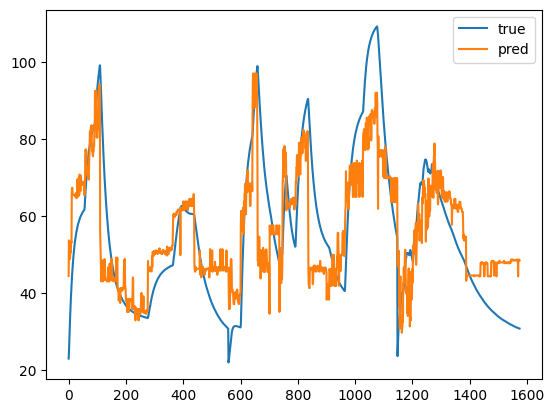

In [36]:
plt.plot(range(len(y_test)), y_test, label="true")
plt.plot(y_pred, label="pred")
plt.legend()
plt.show()

In [37]:
def create_lag_feature(df, feature_name, n_lags=2):
    names = []
    for lag in range(n_lags):
        df[f"{feature_name}_lag_{lag + 1}"] = df[f"{feature_name}"].shift(lag + 1)
        names.append(f"{feature_name}_lag_{lag + 1}")
    return df, names

In [38]:
scaled_df_lagged, f_names = create_lag_feature(scaled_df, "pm", 10)

test_df = scaled_df_lagged[scaled_df_lagged.profile_id.isin(test_profiles)]
train_df = scaled_df_lagged[~ scaled_df_lagged.profile_id.isin(test_profiles)]

test_df = test_df.apply(lambda x: x.fillna(x.mean()), axis=0)
train_df = train_df.apply(lambda x: x.fillna(x.mean()), axis=0)

In [39]:
scaled_df_lagged

,profile_id,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,...,pm_lag_1,pm_lag_2,pm_lag_3,pm_lag_4,pm_lag_5,pm_lag_6,pm_lag_7,pm_lag_8,pm_lag_9,pm_lag_10
0,2,-1.11,-0.92,20.64,0.33,18.79,-1.14,-0.02,1.16,23.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-1.08,-0.89,29.88,0.26,20.72,-1.14,-0.86,2.27,23.21,...,23.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-1.08,-0.86,38.93,0.26,25.09,-1.14,-0.86,2.27,23.29,...,23.21,23.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,-1.08,-0.84,46.18,0.26,29.41,-1.14,-0.86,2.27,23.38,...,23.29,23.21,23.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,-1.07,-0.83,52.68,0.26,33.47,-1.14,-0.86,2.27,23.51,...,23.38,23.29,23.21,23.16,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22211,81,-1.28,2.26,81.42,0.40,79.46,-1.20,1.06,-0.40,58.09,...,57.95,57.80,57.67,57.52,57.37,57.23,57.07,56.91,56.77,56.61
22212,81,-1.29,2.27,81.42,0.40,79.46,-1.20,1.06,-0.40,58.22,...,58.09,57.95,57.80,57.67,57.52,57.37,57.23,57.07,56.91,56.77
22213,81,-1.29,2.27,81.42,0.40,79.46,-1.20,1.06,-0.40,58.37,...,58.22,58.09,57.95,57.80,57.67,57.52,57.37,57.23,57.07,56.91
22214,81,-1.29,2.27,81.41,0.40,79.46,-1.20,1.06,-0.40,58.51,...,58.37,58.22,58.09,57.95,57.80,57.67,57.52,57.37,57.23,57.07


In [40]:
X_train, y_train = train_df[X_cols_names + f_names], train_df["pm"]
X_test, y_test = test_df[X_cols_names + f_names], test_df["pm"]


In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

format(mse(y_test, y_pred), "f")

'1.463314'

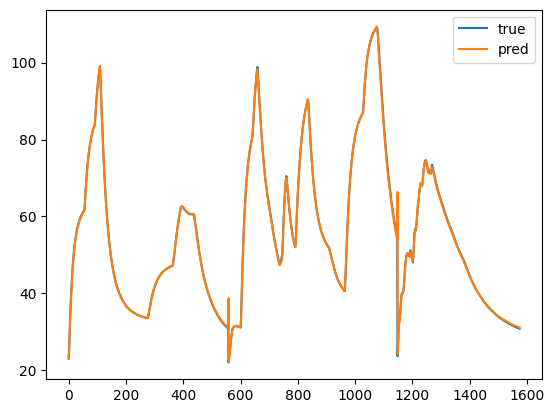

In [42]:
plt.plot(range(len(y_test)), y_test, label="true")
plt.plot(y_pred, label="pred")
plt.legend()
plt.show()

In [43]:
from sklearn.model_selection import RandomizedSearchCV
randomizedsearch = RandomizedSearchCV(xgb1, xgb_parameters, n_iter=20, verbose=2, n_jobs=-1)
best_model_random = randomizedsearch.fit(X_train, y_train)
print(best_model_random.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [44]:
y_pred = best_model_random.best_estimator_.predict(X_test)
mse(y_test, y_pred)

2.205126656462073

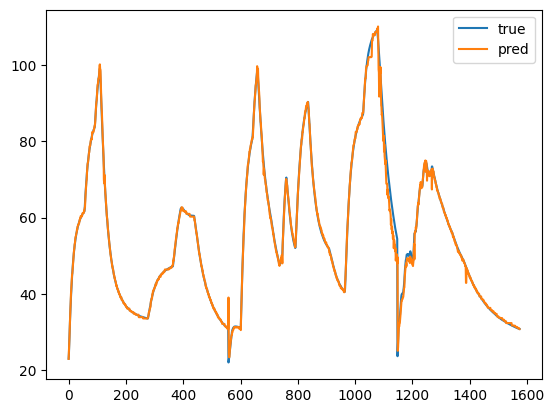

In [45]:
plt.plot(range(len(y_test)), y_test, label="true")
plt.plot(y_pred, label="pred")
plt.legend()
plt.show()